# From Pets to Plant Seedlings

In [1]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289199", h="3298dbabb7", width=700, height=450)

### **1. Introduction & Goals**

**Context: From Pets to Plant Seedlings**

In the previous project (Oxford-IIIT Pets), we built and trained **custom CNNs** from scratch to classify 37 dog and cat breeds.  
That work gave us a deep understanding of:

- **Convolutional operations** (filters, pooling, feature hierarchies).  
- **Parameter efficiency** and how CNNs outperform MLPs for images.  
- The **limitations of shallow architectures** (e.g., 2–3 conv layers) on complex datasets.

**New Challenge: Plant Seedlings Classification**

We now shift domains — from pets to **agricultural plant species** — using the **Plant Seedlings dataset**:

- **12 plant species** (e.g., Maize, Sugar beet, Black-grass).
- **~4,275 RGB images** with varied **lighting, backgrounds, and plant stages**.
- Key challenges:
  - **Intra-class variation** (same plant looks different at different growth stages).
  - **Background noise** (soil, weeds, overlapping plants).
  - **Class imbalance** (some species are underrepresented).

**Why This Dataset?**

- Represents **real-world agricultural tasks** (crop monitoring, weed detection).
- Prepares us to handle **messier datasets** than clean academic ones (like Pets).
- Perfect starting point to explore **transfer learning** with pretrained models.

**Goals of This Notebook (NB01)**

1. **Load and explore the Plant Seedlings dataset** (images + labels).  
2. Apply **image preprocessing** (resize to 224×224, normalize to ImageNet stats).  
3. Visualize **class balance** and **sample images** (identify imbalance early).  
4. Recap **CNN fundamentals** from Project 5 to prepare for **transfer learning** in later notebooks.

**What’s Next (Upcoming Notebooks)**

- **NB02**: Transfer learning with pretrained models (feature extraction vs fine-tuning).  
- **NB03**: Data augmentation and hyperparameter tuning.  
- **NB04**: Model evaluation, error analysis, and generalization strategies.

---

**✅ ALERT: Now you are ready to answer the Multiple Choice Questions for this section!**

---

### **2. Dataset Overview & Loading**

**About the Plant Seedlings Dataset**

- **Source:** Aarhus University Signal Processing Group + University of Southern Denmark  
- **Classes (12 plant species):**
  - Black-grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen,
    Loose Silky-bent, Maize, Scentless Mayweed, Shepherd’s Purse, Small-flowered Cranesbill, Sugar beet
- **Size:** ~4,275 labeled RGB images
- **Characteristics:**
  - Captured under **natural conditions** — with visible soil, varying lighting, and other background clutter.
  - **High intra-class variation:** the same species may look different across growth stages.
  - **Inter-class similarity:** early-stage seedlings can look visually similar across species.

This makes classification **harder** than the Oxford-IIIT Pets dataset used in Project 5, which had cleaner images and more distinct classes.

**Why Resize to 224×224 Pixels?**

In Project 5, we resized images to **128×128** for our *custom CNN* models.  
Here in Project 6, we aim to use **transfer learning with pretrained models** like ResNet or AlexNet. These models were originally trained on **ImageNet**, a massive dataset of 1.2M images across 1,000 classes (dogs, cats, cars, plants, etc.).

- **ImageNet models expect 224×224 input** — this is the standard resolution used during their training.
- By resizing seedlings images to 224×224, we **match the expected input size**, allowing us to reuse pretrained weights effectively.
- 224×224 is also a **good balance**: detailed enough to capture plant structures, but not too large to slow down CPU-based training.


In [2]:
from IPython.display import VimeoVideo

# ImageResizing
VimeoVideo("1114289250", h="3298dbabb7", width=700, height=450)

**Why Use ImageNet Normalization (Mean/Std)?**

- Pretrained CNNs not only expect 224×224 input, but also **specific pixel statistics**:  
  - **Mean:** `[0.485, 0.456, 0.406]`  
  - **Standard Deviation:** `[0.229, 0.224, 0.225]`
- These values are computed from the **entire ImageNet dataset** and represent the typical RGB distribution across millions of natural images.

**Why normalize?**
- Ensures input images are **centered** (mean 0) and **scaled** (std ~1).
- Matches the distribution that pretrained weights were optimized on — crucial for transfer learning to work well.
- Without this, the pretrained features would misinterpret brightness/contrast and hurt performance.

Ref: <br>
https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670<br>
https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2<br>
https://discuss.pytorch.org/t/normalizing-with-imagenet-mean-and-std-vs-normalizing-with-my-own-datasets-mean-and-std/94953<br>


**Visualization Goals**

- Display a **grid of sample images** (one per class) to familiarize ourselves with the data.  
- Plot a **class distribution chart** to identify imbalance (e.g., Loose Silky-bent vs. Common wheat).  
- This helps anticipate challenges (e.g., some species may dominate the dataset and bias the model).

**Key Shift from Project 5 → Project 6**

- **Project 5:** Pets dataset, 128×128, custom CNN (trained from scratch).  
- **Project 6:** Seedlings dataset, 224×224, transfer learning (pretrained ImageNet CNNs).  
- **Why shift?** Leveraging pretrained networks can drastically reduce training time and improve accuracy, especially when data is limited or noisy.

In [3]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289318", h="3298dbabb7", width=700, height=450)

**One-Time Preprocessing (Build Train/Test Split in NB01)**

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# -----------------------------
# 0. Control Flag
# -----------------------------
# Set it to False to skip this step as the data is already preprocessed.
# Set this flag to True if you want to run the data splitting and copying process. Not necessary.
RUN_PREPROCESSING = False


raw_data_dir = "data"
# Target folder where split data will be stored
split_data_dir = "data/plant-seedlings"

if RUN_PREPROCESSING:
    # -----------------------------
    # 1. Paths
    # -----------------------------
    
    train_dir = os.path.join(split_data_dir, "train")
    test_dir  = os.path.join(split_data_dir, "test")
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # -----------------------------
    # 2. Split Logic
    # -----------------------------
    for class_name in os.listdir(raw_data_dir):
        class_path = os.path.join(raw_data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        if class_name == "plant-seedlings":  # Skip the target folder
            continue
        if class_name.startswith('.'):  # Skip hidden folders like .ipynb_checkpoints
            continue
        # All images for this class
        images = [
            os.path.join(class_path, f)
            for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
    
        # 80-20 train/test split
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    
        # Create class subfolders in train/test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
        # Copy images to respective folders
        for img in train_imgs:
            shutil.copy(img, os.path.join(train_dir, class_name))
        for img in test_imgs:
            shutil.copy(img, os.path.join(test_dir, class_name))
    
    print(f"Train/Test split created at: {split_data_dir}")

else:
    print("You've chosen not to run the preprocessing script. No worries, the data is already preprocessed and ready to use! ✅")

You've chosen not to run the preprocessing script. No worries, the data is already preprocessed and ready to use! ✅


**Checking the downloaded dataset structure**

In [5]:
for class_name in os.listdir(raw_data_dir):
    class_path = os.path.join(raw_data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    print(f"{class_name}: {len(images)} images")

Black-grass: 333 images
Charlock: 454 images
Cleavers: 348 images
Common Chickweed: 716 images
Common wheat: 258 images
Fat Hen: 543 images
Loose Silky-bent: 819 images
Maize: 260 images
Scentless Mayweed: 608 images
Shepherd’s Purse: 276 images
Small-flowered Cranesbill: 580 images
Sugar beet: 464 images
plant-seedlings: 0 images


**Loading the Train and Test data**

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# 1. Path to split dataset
# -----------------------------
data_path = "./data/plant-seedlings"

train_dir = os.path.join(data_path, "train")
test_dir  = os.path.join(data_path, "test")

# -----------------------------
# 2. Transformations
# -----------------------------
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# -----------------------------
# 3. Load datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 4. Verify
# -----------------------------
print(f"Classes: {train_dataset.classes}")
print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Train samples: 4724 | Test samples: 2769


**Visualize Sample Images**

In [8]:
from matplotlib import pyplot as plt
import numpy as np

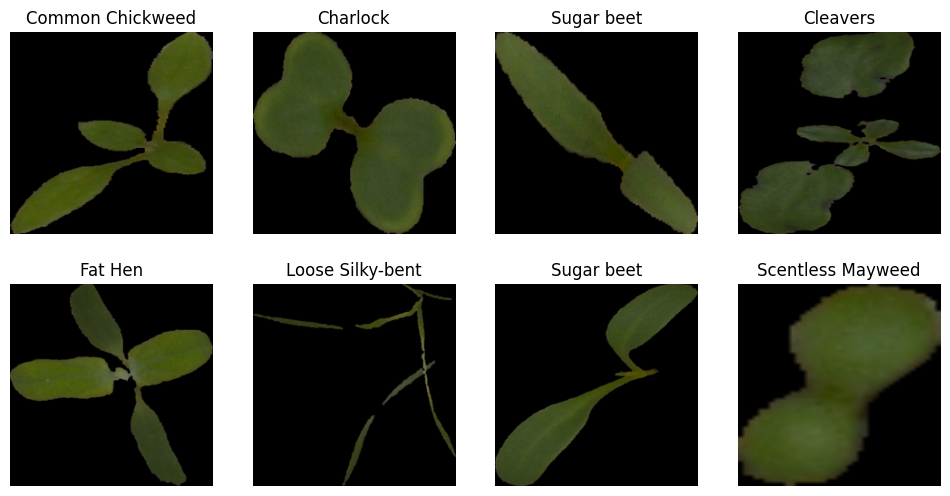

In [11]:
# ---------------------------------------------------------
# Display images after reversing normalization
# ---------------------------------------------------------
# Why do we "unnormalize" here?
# - During preprocessing, images were normalized to ImageNet mean/std
#   so model training works correctly (centered data, stable gradients).
# - For visualization, we must reverse this step to recover the original
#   color range (0–1) so the images look natural.
# ---------------------------------------------------------

def imshow(inp, title=None):
    """Display a tensor image after unnormalizing (ImageNet stats)."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Show first 8 training images
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    imshow(images[i], title=train_dataset.classes[labels[i]])
plt.show()


**Class Balance Visualization**

In [39]:
train_dataset.samples

[('./data/plant-seedlings/train/Black-grass/10.png', 0),
 ('./data/plant-seedlings/train/Black-grass/101.png', 0),
 ('./data/plant-seedlings/train/Black-grass/102.png', 0),
 ('./data/plant-seedlings/train/Black-grass/103.png', 0),
 ('./data/plant-seedlings/train/Black-grass/104.png', 0),
 ('./data/plant-seedlings/train/Black-grass/105.png', 0),
 ('./data/plant-seedlings/train/Black-grass/106.png', 0),
 ('./data/plant-seedlings/train/Black-grass/107.png', 0),
 ('./data/plant-seedlings/train/Black-grass/108.png', 0),
 ('./data/plant-seedlings/train/Black-grass/11.png', 0),
 ('./data/plant-seedlings/train/Black-grass/110.png', 0),
 ('./data/plant-seedlings/train/Black-grass/111.png', 0),
 ('./data/plant-seedlings/train/Black-grass/112.png', 0),
 ('./data/plant-seedlings/train/Black-grass/113.png', 0),
 ('./data/plant-seedlings/train/Black-grass/114.png', 0),
 ('./data/plant-seedlings/train/Black-grass/115.png', 0),
 ('./data/plant-seedlings/train/Black-grass/116.png', 0),
 ('./data/plant-

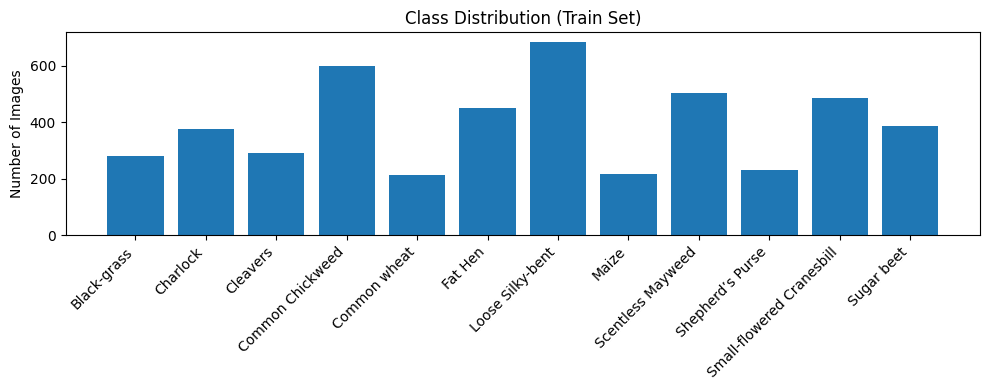

In [13]:
import collections

# Count samples per class
class_counts = collections.Counter([label for _, label in train_dataset.samples])

# Convert to list aligned with class_names
counts = [class_counts[i] for i in range(len(train_dataset.classes))]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(train_dataset.classes, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution (Train Set)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

**Reflection**

- The **Plant Seedlings dataset** introduces greater **visual complexity** than the Oxford Pets dataset:
  - Background clutter (soil, grass) and similar early-stage appearances across species.
  - Pronounced **class imbalance** (e.g., Loose Silky-bent vs Common wheat).

- By standardizing inputs to **224×224** and using **ImageNet mean/std normalization**, we align with **pretrained CNNs** (ResNet, AlexNet) that we’ll leverage in the next notebooks.

- This step bridges **custom CNN training (Project 5)** and **transfer learning (Project 6)** — preparing us to exploit deeper, pretrained features.

> **Note**: We will create a dedicated validation split later (in Section 4) for model tuning and monitoring.

---

**✅ ALERT: Now you are ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.1.2.1: Build a Custom Transform (Different IMG_SIZE)**

📘 Instruction </br>
Create a new transform that resizes images to CT_IMG_SIZE = 128 (instead of 224), applies ToTensor(), and uses the same ImageNet normalization. Then apply it to train_dir with ImageFolder and create a DataLoader. Finally, grab one batch and store its shape in CT_batch_shape_128.

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

CT_IMG_SIZE = 128
CT_transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

CT_train_dataset_128 = datasets.ImageFolder(train_dir, transform=CT_transform_128)
CT_train_loader_128  = DataLoader(CT_train_dataset_128, batch_size=32, shuffle=True)

CT_images_128, CT_labels_128 = next(iter(CT_train_loader_128))
CT_batch_shape_128 = CT_images_128.shape
print("CT_batch_shape_128:", CT_batch_shape_128)


CT_batch_shape_128: torch.Size([32, 3, 128, 128])


---

**✅ Code Task 6.1.2.2: Create a Small Subset Loader (Quick Iteration)**

📘 Instruction</br>
For quick experiments, let’s create a subset of 200 images from the training set using indices range(200). Build a DataLoader with batch_size=16 and shuffle=True. Store the first batch shape into CT_subset_batch_shape.

In [23]:
from torch.utils.data import Subset, DataLoader

CT_subset_indices = list(range(200))   # 200 samples
CT_train_subset   = Subset(train_dataset, CT_subset_indices)
CT_subset_loader  = DataLoader(CT_train_subset, batch_size=16, shuffle=True)

CT_subset_images, CT_subset_labels = next(iter(CT_subset_loader))
CT_subset_batch_shape = CT_subset_images.shape
print("CT_subset_batch_shape:", CT_subset_batch_shape)


CT_subset_batch_shape: torch.Size([16, 3, 224, 224])


---

**✅ Code Task 6.1.2.3: Implement an Unnormalize Helper & Visualize**

📘 Instruction</br>
Implement a function `CT_unnormalize(img_tensor)` that reverses ImageNet normalization and returns a numpy HWC image clipped to `[0,1]`. Use it to visualize one image from `train_loader` (or from `CT_train_loader_128`) and print the returned array shape as `CT_img_unnorm_shape`.

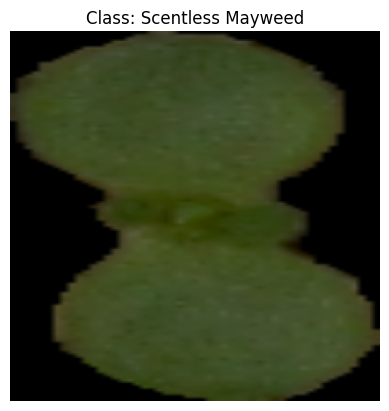

CT_img_unnorm_shape: (224, 224, 3)


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def CT_unnormalize(img_tensor):
    # img_tensor: (C,H,W), normalized by ImageNet stats
    mean = np.array([0.485, 0.456, 0.406])[..., None, None]
    std  = np.array([0.229, 0.224, 0.225])[..., None, None]
    img_np = img_tensor.detach().cpu().numpy()
    img_np = img_np * std + mean           # de-normalize (C,H,W)
    img_np = np.clip(img_np, 0.0, 1.0)
    img_hwc = np.transpose(img_np, (1, 2, 0))  # to HWC
    return img_hwc

# Take one sample
CT_one_img, CT_one_label = next(iter(train_loader))
CT_img_vis = CT_unnormalize(CT_one_img[0])
CT_img_unnorm_shape = CT_img_vis.shape

plt.imshow(CT_img_vis)
plt.title(f"Class: {train_dataset.classes[CT_one_label[0]]}")
plt.axis("off")
plt.show()

print("CT_img_unnorm_shape:", CT_img_unnorm_shape)


---

**✅ Code Task 6.1.2.4: Build Custom Train/Test Loaders (Different Batch Sizes)**

📘 Instruction</br>
Create separate DataLoaders with different batch sizes:
- CT_train_loader_bs20 with batch_size=20, shuffle=True
- CT_test_loader_bs50 with batch_size=50, shuffle=False </br>
Fetch one batch from each and store shapes as CT_train_bs20_shape and CT_test_bs50_shape.

In [30]:
CT_train_loader_bs20 = DataLoader(train_dataset, batch_size=20, shuffle=True)
CT_test_loader_bs50  = DataLoader(test_dataset,  batch_size=50, shuffle=False)

CT_tr20_images, CT_tr20_labels = next(iter(CT_train_loader_bs20))
CT_te50_images, CT_te50_labels = next(iter(CT_test_loader_bs50))

CT_train_bs20_shape = CT_tr20_images.shape
CT_test_bs50_shape  = CT_te50_images.shape

print("CT_train_bs20_shape:", CT_train_bs20_shape)
print("CT_test_bs50_shape:",  CT_test_bs50_shape)


CT_train_bs20_shape: torch.Size([20, 3, 224, 224])
CT_test_bs50_shape: torch.Size([50, 3, 224, 224])


---

In [33]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289339", h="3298dbabb7", width=700, height=450)

### **3. Quick CNN Recap (from Project 5)**

Before we dive into **transfer learning**, let’s briefly revisit what we learned about CNNs in **Project 5 (Oxford-IIIT Pets)**.

**What is the CNN pipeline?**

A **Convolutional Neural Network (CNN)** transforms raw image pixels into class probabilities through a structured hierarchy:

1. **Convolution Layers**  
   - Apply filters (kernels) to detect **local features** (edges, corners).  
2. **Pooling Layers**  
   - Downsample feature maps to reduce spatial size and enforce **translation invariance**.  
3. **Flatten**  
   - Convert 2D feature maps into a 1D vector for dense layers.  
4. **Fully Connected Layers (FC)**  
   - Combine features for **class-level reasoning**.  
5. **Softmax**  
   - Produce probabilities across all classes.

**Baseline CNN (Project 5)**

Here’s a schematic of the **2-conv + 2-FC** model we built for pet breed classification:

```text
Input (3 × 128 × 128)
        │
[Conv2D 3→16, 3×3] → ReLU → MaxPool(2×2)
        │
[Conv2D 16→32, 3×3] → ReLU → MaxPool(2×2)
        │
Flatten (32 × 32 × 32)
        │
[FC: 32×32×32 → 128] → ReLU
        │
[FC: 128 → 37] → Softmax

```
**Key Takeaways from Project 5**

- **Parameter efficiency:**  
  CNNs re-use filters (weight sharing), unlike MLPs where each pixel connects independently.  
- **Feature hierarchy:**  
  - Early layers detect edges & colors.  
  - Deeper layers detect textures, shapes, and eventually object parts.  
- **Challenges observed:**  
  - Shallow CNN struggled with complex breed variations.  
  - Overfitting without augmentation or regularization.

**Why Transfer Learning Now?**

Instead of **training CNNs from scratch** on every dataset:
- We can use **pretrained networks** (e.g., ResNet, AlexNet) trained on **ImageNet (1.2M images, 1000 classes)**.
- These models already **learned general visual features** (edges, shapes, textures) that transfer well to new tasks.
- We only need to **fine-tune or replace the final layers** for our target classes (12 plant species).

This shift is crucial for **Project 6 (Plant Seedlings)**:
- Smaller dataset (~4k images) benefits from pretrained features.
- Faster convergence and better accuracy with limited data.

**Next:**  
We load **pretrained architectures** (ResNet/AlexNet) and adapt them for **12-class plant classification**.

---

**✅ ALERT: Now you are ready to answer the Multiple Choice Questions for this section!**

---

In [35]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289369", h="3298dbabb7", width=700, height=450)

In [36]:
import os
import shutil
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Paths
# -----------------------------
data_path = "./data/plant-seedlings"
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")

os.makedirs(val_dir, exist_ok=True)

# -----------------------------
# 2. Create validation split (15% of train)
# -----------------------------
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # All images in this class
    images = [
        os.path.join(class_path, f)
        for f in os.listdir(class_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Skip if validation already exists for this class
    val_class_path = os.path.join(val_dir, class_name)
    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path, exist_ok=True)

    # 15% split for validation
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    # Move validation images
    for img in val_imgs:
        dest_path = os.path.join(val_class_path, os.path.basename(img))
        shutil.move(img, dest_path)

print(f"Validation split created at: {val_dir}")

# -----------------------------
# 3. Load datasets (train/val/test)
# -----------------------------
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Paths for train, val, test
test_dir = os.path.join(data_path, "test")

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 4. Verify splits
# -----------------------------
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Validation split created at: ./data/plant-seedlings/val
Train samples: 4010
Val samples: 2505
Test samples: 2769
Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']


---

**✅ Code Task 6.1.4.1: Create Train/Val Split (No File Moves) & Verify Class Balance**

📘 Instruction</br>
Instead of physically moving files, we’ll create a validation split in-memory using Subset indices:
- Split 15% of training indices into validation (use np.random.seed(42) and np.random.permutation).
- Build CT_train_dataset_split and CT_val_dataset_split as Subset(train_dataset, ...).
- Create loaders with batch_size=32.
- Compute class counts for both splits and store as dicts CT_train_class_counts and CT_val_class_counts mapping class_name -> count. Finally, print both dicts.

In [37]:
import numpy as np
from torch.utils.data import Subset, DataLoader
import collections

num_train = len(train_dataset)
CT_perm   = np.random.RandomState(42).permutation(num_train)
CT_val_sz = int(0.15 * num_train)     # 15%
CT_val_idx = CT_perm[:CT_val_sz]
CT_trn_idx = CT_perm[CT_val_sz:]

CT_train_dataset_split = Subset(train_dataset, CT_trn_idx)
CT_val_dataset_split   = Subset(train_dataset, CT_val_idx)

CT_train_loader_split = DataLoader(CT_train_dataset_split, batch_size=32, shuffle=True)
CT_val_loader_split   = DataLoader(CT_val_dataset_split,   batch_size=32, shuffle=False)

# Count class distribution in each split
def CT_count_classes(subset_ds, class_names):
    counts = collections.Counter()
    # subset_ds.indices maps into original dataset.samples (path, label)
    for idx in subset_ds.indices:
        _, lbl = train_dataset.samples[idx]
        counts[class_names[lbl]] += 1
    return dict(counts)

CT_train_class_counts = CT_count_classes(CT_train_dataset_split, train_dataset.classes)
CT_val_class_counts   = CT_count_classes(CT_val_dataset_split,   train_dataset.classes)

print("CT_train_class_counts:", CT_train_class_counts)
print("CT_val_class_counts:",   CT_val_class_counts)


CT_train_class_counts: {'Loose Silky-bent': 497, 'Shepherd’s Purse': 166, 'Common Chickweed': 425, 'Black-grass': 187, 'Charlock': 263, 'Scentless Mayweed': 381, 'Cleavers': 220, 'Maize': 154, 'Fat Hen': 326, 'Small-flowered Cranesbill': 350, 'Common wheat': 158, 'Sugar beet': 282}
CT_val_class_counts: {'Maize': 31, 'Small-flowered Cranesbill': 64, 'Common Chickweed': 85, 'Loose Silky-bent': 85, 'Charlock': 56, 'Black-grass': 51, 'Shepherd’s Purse': 29, 'Scentless Mayweed': 47, 'Sugar beet': 46, 'Fat Hen': 56, 'Common wheat': 22, 'Cleavers': 29}


---

**✅ ALERT: Now you are ready to answer the Multiple Choice Questions for this section!**

---

### **5. Next Steps**

**What we accomplished in this notebook:**

- Introduced the **Plant Seedlings dataset** and its real-world agricultural challenges.
- Standardized images to **224×224** and normalized using **ImageNet statistics**.
- Explored dataset composition:
  - Class names and visual examples.
  - Imbalance across classes (important for training strategies).
- Created a clean **train/val/test split**:
  - Train: 68% (model fitting)
  - Val: 12% (hyperparameter tuning & early stopping)
  - Test: 20% (final evaluation)

- Recapped **CNN fundamentals** from Project 5 to prepare for deeper architectures.


**What’s coming in NB02:**

- Build and train a **custom CNN (LeNet-style)** from scratch on the seedlings dataset.
- Evaluate its **accuracy and per-class performance**.
- Identify **limitations of scratch models**, motivating **transfer learning** in NB03.


**Big Picture:**

This notebook bridges our earlier work (Pets dataset, 128×128 images, custom CNNs) with the more advanced world of **pretrained networks and agricultural applications**.  
By the end of Project 6, we’ll have compared **scratch vs. transfer learning** approaches and discussed their trade-offs for real-world use.
